In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
base_dir = './data/Cropped Dataset/'
# uncomment the following line to use non-pre-processed data
# base_dir = './data/New Masks Dataset/'
train_dir = base_dir + 'Train/'
val_dir = base_dir + 'Validation/'
test_dir = base_dir + 'Test/'
batch_size = 32

data_gen_args_base = dict(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False
)

# training data
train_data_generator = ImageDataGenerator(**data_gen_args_base)
train_set = train_data_generator.flow_from_directory(directory=train_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# validation data
val_data_generator = ImageDataGenerator(**data_gen_args_base)
val_set = val_data_generator.flow_from_directory(directory=val_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# test data
test_data_generator = ImageDataGenerator(**data_gen_args_base)
test_set = test_data_generator.flow_from_directory(directory=test_dir,
                                                    target_size=(128, 128),
                                                    batch_size=batch_size,
                                                    class_mode='binary')


Found 1830 images belonging to 2 classes.
Found 1098 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


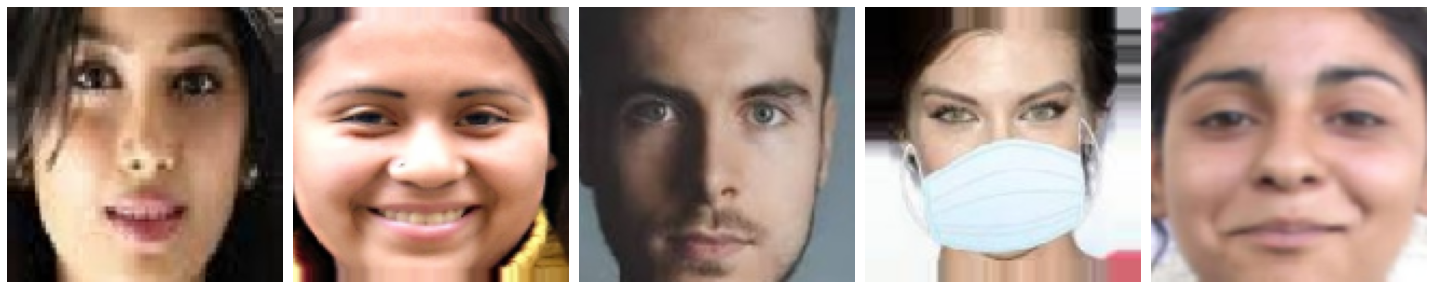

In [5]:
def plotImage(img):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(img)
    ax.axis('off')
    plt.show()
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_set)
plotImages(sample_training_images[:5])

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, MaxPool2D, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
INPUT_SHAPE = train_set.image_shape

cnn = Sequential()
cnn.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu",input_shape=INPUT_SHAPE))
cnn.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
cnn.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Conv2D(filters=256,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Conv2D(filters=512,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Flatten())
cnn.add(Dense(units=512,activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=1024,activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=1,activation="sigmoid"))
cnn.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [8]:
early_stop = EarlyStopping(monitor="val_loss",patience=4,mode="min") #Ensure the model doesn't overfit

In [9]:
history = cnn.fit(x=train_set, batch_size=batch_size, epochs=20, callbacks=early_stop, validation_data=val_set)

Epoch 1/20
58/58 [==============================] - 102s 2s/step - loss: 0.3577 - accuracy: 0.8634 - val_loss: 0.1319 - val_accuracy: 0.9435
Epoch 2/20
58/58 [==============================] - 105s 2s/step - loss: 0.1069 - accuracy: 0.9738 - val_loss: 0.1082 - val_accuracy: 0.9781
Epoch 3/20
58/58 [==============================] - 104s 2s/step - loss: 0.0759 - accuracy: 0.9814 - val_loss: 0.1097 - val_accuracy: 0.9736
Epoch 4/20
58/58 [==============================] - 106s 2s/step - loss: 0.1714 - accuracy: 0.9607 - val_loss: 0.3366 - val_accuracy: 0.8862
Epoch 5/20
58/58 [==============================] - 103s 2s/step - loss: 0.1301 - accuracy: 0.9689 - val_loss: 0.1482 - val_accuracy: 0.9627
Epoch 6/20
58/58 [==============================] - 105s 2s/step - loss: 0.0771 - accuracy: 0.9820 - val_loss: 0.1125 - val_accuracy: 0.9791


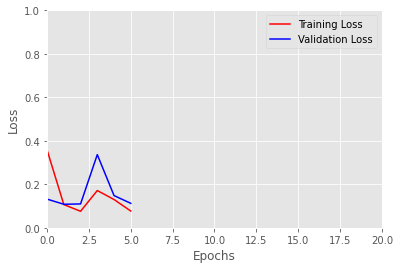

In [10]:
plt.xlim(0, 20)
plt.ylim(0,1)

plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

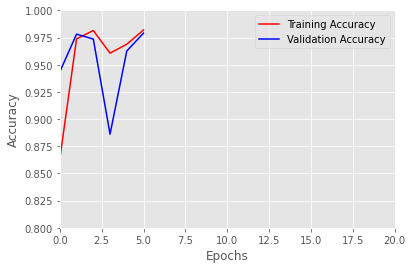

In [11]:
plt.xlim(0, 20)
plt.ylim(0.8,1)

plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
result = cnn.evaluate(test_set)
dict(zip(cnn.metrics_names, result))

21/21 [==============================] - 6s 280ms/step - loss: 0.2081 - accuracy: 0.9530


{'loss': 0.20813564956188202, 'accuracy': 0.9529590010643005}

In [13]:
import cv2
import random
import os, os.path
import dlib 
import imutils
from imutils import face_utils

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

# function to use dlib to detect an almost full face
def apply_dlib(img):
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# detect faces in the grayscale image
	rects = detector(gray, 1)
	# loop over the face detections
	if len(rects) == 0:
		print('No nose/mouth detected')
	else: 
		print('Nose or mouth detected!!! Improper use of a mask!!!')
	for (i, rect) in enumerate(rects):
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
		# convert dlib's rectangle to a OpenCV-style bounding box
		# [i.e., (x, y, w, h)], then draw the face bounding box
		(x, y, w, h) = face_utils.rect_to_bb(rect)
		cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
		# show the face number
		cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
		# loop over the (x, y)-coordinates for the facial landmarks
		# and draw them on the img
		for (x, y) in shape:
			cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
	# show the output img with the face detections + facial landmarks
	plotImage(img)


No nose/mouth detected


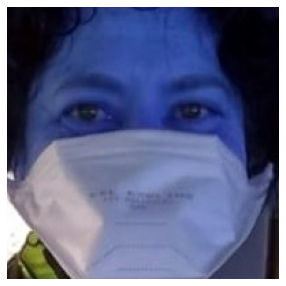

No nose/mouth detected


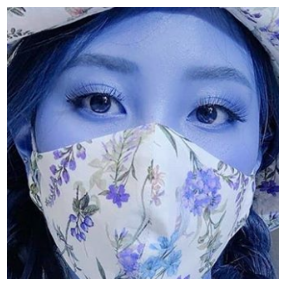

No nose/mouth detected


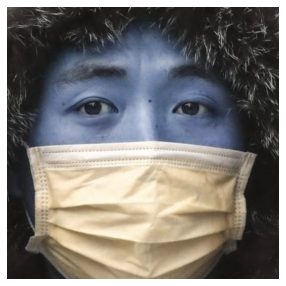

Nose or mouth detected!!! Improper use of a mask!!!


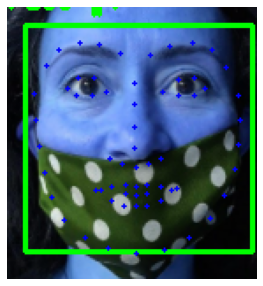

No nose/mouth detected


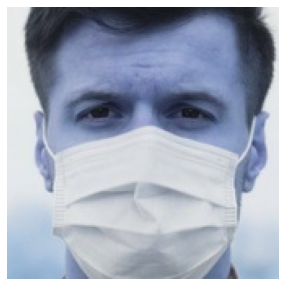

Nose or mouth detected!!! Improper use of a mask!!!


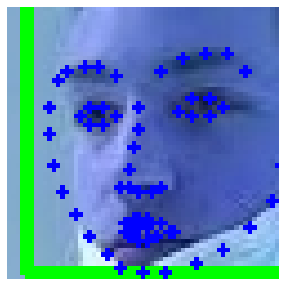

Nose or mouth detected!!! Improper use of a mask!!!


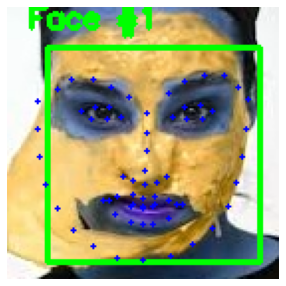

In [14]:
# apply_dlib(image)
DIR = './data/Improper Dataset/'
imageFiles = os.listdir(DIR)
for imageFile in imageFiles:
	image = cv2.imread(DIR + imageFile)
	apply_dlib(image)